# Baseline Text Classification


ACEInhibitors dataset from: https://www.dropbox.com/sh/ud5sf1fy6m7o219/AAD9pkY5gYe_XYV2oHDw68uva?dl=0

## Libraries and methods

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#libraries
import numpy as np
import pandas as pd
import math
import re
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import regexp_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from pathlib import Path  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#preprocessing methods 

def clean_text(df, col):
    """A function for keeping only alpha-numeric characters and replacing all 
    white space with a single space.
    """
    return df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', str(x).lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())

def flatten_words(list1d, get_unique=False):
    qa = [s.split() for s in list1d]
    if get_unique:
        return sorted(list(set([w for sent in qa for w in sent])))
    else:
        return [w for sent in qa for w in sent]

def features(df, text, text_clean):
    df = df.copy()
    df['n_questionmarks'] = count_pattern(df, text, '\?')
    df['n_periods'] = count_pattern(df, text, '\.')
    df['n_apostrophes'] = count_pattern(df, text, '\'')
    df['first_word'] = df[text_clean].apply(lambda x: split_on_word(x)[0])
    question_words = ['what', 'how', 'why', 'is']
    for w in question_words:
        col_wc = 'n_' + w
        col_fw = 'fw_' + w
        df[col_wc] = count_pattern(df, text_clean, w)
        df[col_fw] = (df.first_word == w) * 1
        
    del df['first_word']
    
    df['n_words'] = df[text].apply(lambda x: len(split_on_word(x)))
    return df

def count_pattern(df, col, pattern):
    """Count the occurrences of `pattern`
    in df[col].
    """
    df = df.copy()
    return df[col].str.count(pattern)

def split_on_word(text):
    """Use regular expression tokenizer.
    Keep apostrophes.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    if type(text) is list:
        return [regexp_tokenize(sentence, pattern="\w+(?:[-']\w+)*") for sentence in text]
    else:
        return regexp_tokenize(text, pattern="\w+(?:[-']\w+)*")

In [4]:
def from_list_values_to_columns(col, k, print=False): 

#obtaining the unique values 

  dataset[k][col] = dataset[k][col].apply(eval)

  col_dict = {} 
  for i in dataset[k][col]: #obtain value_count in a dictionary
    for j in i:
        if j not in col_dict:
            col_dict[j] = 1 #new column
        else:
            col_dict[j] += 1 #update column count

  series = pd.Series([x for _list in dataset[k][col] for x in _list]) #reducing its dimensions from 2 to 1 

  if print == True:
    print(series.value_counts()) #display value count

#creating new binary columns 

  bool_dict = {} #create boolean dict (the binary value for every colum in col_dict and for every row in the dataset[k])
  for i, item in enumerate(col_dict.keys()): 
    bool_dict[item] = dataset[k][col].apply(lambda x: item in x)

  return pd.DataFrame(bool_dict).astype(int)

In [5]:
def evalmetrics(y_test, test_predicted, labels, new_row, res): 

  #f-2 score
  f2 = fbeta_score(y_test, test_predicted, average='binary', beta=2)
  print("\nF-2 score with dataset", new_row["df"], ":", f2, "\n")

  #f-3 score
  f3 = fbeta_score(y_test, test_predicted, average='binary', beta=3)
  print("F-3 score with dataset", new_row["df"], ":", f3, "\n")

  #confusion matrix
  cm = confusion_matrix(y_test, test_predicted, labels=labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  title = new_row["model"] + " confusion matrix on dataset " + new_row["df"]
  disp.ax_.set_title(title)

  #evaluation metrics
  report = classification_report(y_test, test_predicted, output_dict=True)
  display(pd.DataFrame(report).transpose().round(decimals=3))

  new_row.update({'f2_score' : f2, 'f3_score' : f3})
  res = res.append(new_row, ignore_index=True)

  return res

In [6]:
def compute_fbeta_avg(res): 

  for i in res["df"].unique(): 
    for j in res["model"].unique(): 
      condition = (res["df"] == i) & (res["model"] == j)

      #computing f2 mean score
      res.loc[condition, 'f2_avg'] = res["f2_score"].where(condition).mean()

      #computing f3 mean score
      res.loc[condition, 'f3_avg'] = res["f3_score"].where(condition).mean()

  return res

## Import of data

In [7]:
#import of data
data = pd.read_csv('/content/ACEInhibitors.tsv', sep='\t')
print(data.shape)
pd.set_option('display.max_columns', None)
display(data.head(3))

(2544, 53)


,PMID,OWN,STAT,DCOM,LR,IS,VI,IP,DP,Title,PG,Abstract,FAU,AU,AD,LA,PT,PL,TA,JT,JID,RN,SB,MH,EDAT,MHDA,CRDT,PHST,AID,PST,SO,GR,CIN,EIN,RF,CI,PMC,CON,OTO,OT,IR,FIR,IRAD,CRI,LID,CN,TT,OID,SPIN,DEP,ORI,RIN,Label
0,10024335,NLM,MEDLINE,19990309,20190722,0194-911X (Print) 0194-911X (Linking),33,2,1999 Feb,Distinct and combined vascular effects of ACE ...,719-25,Hypercholesterolemia and hypertension are freq...,"['Nazzaro, P', 'Manzari, M', 'Merlo, M', 'Trig...","['Nazzaro P', 'Manzari M', 'Merlo M', 'Triggia...",['Department of Clinical Methodology and Medic...,['eng'],"['Clinical Trial', 'Controlled Clinical Trial'...",United States,Hypertension,"Hypertension (Dallas, Tex. : 1979)",7906255,['0 (Angiotensin-Converting Enzyme Inhibitors)...,IM,"['Adult', 'Angiotensin-Converting Enzyme Inhib...",1999/02/19 00:00,1999/02/19 00:01,['1999/02/19 00:00'],"['1999/02/19 00:00 [pubmed]', '1999/02/19 00:0...",['10.1161/01.hyp.33.2.719 [doi]'],ppublish,Hypertension. 1999 Feb;33(2):719-25. doi: 10.1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10027665,NLM,MEDLINE,19990506,20190813,0031-6970 (Print) 0031-6970 (Linking),54,11,1999 Jan,Computerized surveillance of adverse drug reac...,887-92,OBJECTIVE: To implement and measure the effect...,"['Levy, M', 'Azaz-Livshits, T', 'Sadan, B', 'S...","['Levy M', 'Azaz-Livshits T', 'Sadan B', 'Shal...","['Department of Medicine, Hadassah University ...",['eng'],"['Journal Article', ""Research Support, Non-U.S...",Germany,Eur J Clin Pharmacol,European journal of clinical pharmacology,1256165,NaN,IM,['Adverse Drug Reaction Reporting Systems/econ...,1999/02/23 00:00,1999/02/23 00:01,['1999/02/23 00:00'],"['1999/02/23 00:00 [pubmed]', '1999/02/23 00:0...",['10.1007/s002280050571 [doi]'],ppublish,Eur J Clin Pharmacol. 1999 Jan;54(11):887-92. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10027935,NLM,MEDLINE,19990416,20161124,0085-2538 (Print) 0085-2538 (Linking),55,3,1999 Mar,Glomerular size-selective dysfunction in NIDDM...,984-94,BACKGROUND: In patients with insulin-dependent...,"['Ruggenenti, P', 'Mosconi, L', 'Sangalli, F',...","['Ruggenenti P', 'Mosconi L', 'Sangalli F', 'C...","['Department of Kidney Research, Mario Negri I...",['eng'],"['Clinical Trial', 'Journal Article', 'Randomi...",United States,Kidney Int,Kidney international,0323470,['0 (Angiotensin-Converting Enzyme Inhibitors)...,IM,"['Adult', 'Aged', 'Angiotensin-Converting Enzy...",1999/02/23 00:00,1999/02/23 00:01,['1999/02/23 00:00'],"['1999/02/23 00:00 [pubmed]', '1999/02/23 00:0...","['10.1046/j.1523-1755.1999.055003984.x [doi]',...",ppublish,Kidney Int. 1999 Mar;55(3):984-94. doi: 10.104...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Columns analysis

### Columns distribution

In [8]:
print(data.columns)

Index(['PMID', 'OWN', 'STAT', 'DCOM', 'LR', 'IS', 'VI', 'IP', 'DP', 'Title',
       'PG', 'Abstract', 'FAU', 'AU', 'AD', 'LA', 'PT', 'PL', 'TA', 'JT',
       'JID', 'RN', 'SB', 'MH', 'EDAT', 'MHDA', 'CRDT', 'PHST', 'AID', 'PST',
       'SO', 'GR', 'CIN', 'EIN', 'RF', 'CI', 'PMC', 'CON', 'OTO', 'OT', 'IR',
       'FIR', 'IRAD', 'CRI', 'LID', 'CN', 'TT', 'OID', 'SPIN', 'DEP', 'ORI',
       'RIN', 'Label'],
      dtype='object')


In [9]:
data.rename(columns={"STAT" : "status"}, inplace=True)
data["status"].value_counts()

MEDLINE               2539
PubMed-not-MEDLINE       5
Name: status, dtype: int64

Useless

In [10]:
data.rename(columns={"VI" : "volume_number"}, inplace=True)
data["volume_number"].value_counts()

15              68
14              65
12              62
13              61
16              59
                ..
290              1
107 Suppl 5      1
146              1
63 Spec No 1     1
339              1
Name: volume_number, Length: 243, dtype: int64

In [11]:
data.rename(columns={"IP" : "issue"}, inplace=True)
data["issue"].value_counts()

3       314
1       311
2       301
5       250
4       239
       ... 
9153      1
42        1
44        1
9268      1
9145      1
Name: issue, Length: 147, dtype: int64

VI and IP both contain non numeric values.

In [12]:
data.rename(columns={"DP" : "publication_date"}, inplace=True)

print(data["publication_date"].value_counts())

1994           33
2000 Dec       29
2001 Feb       26
2001 Dec       26
2001 Mar       25
               ..
2002 Nov 20     1
2002 Nov 15     1
2002 Oct 14     1
2002 Sep 7      1
1998 Nov 30     1
Name: publication_date, Length: 565, dtype: int64


In [13]:
data.rename(columns={"FAU" : "full_authors"}, inplace=True)
data["full_authors"].value_counts()

['Kaplan, N M']                                                       4
['Cohen, J S']                                                        4
['Deedwania, P C']                                                    3
['Vidt, D G']                                                         3
['Pitt, B']                                                           3
                                                                     ..
['Carter, J D', 'Valeriano-Marcet, J', 'Kanik, K S', 'Vasey, F B']    1
['Bomann, J Scott', 'Peckler, Bradley F']                             1
['Coppo, R', 'Chiesa, M', 'Peruzzi, L', 'Amore, A']                   1
['Nyawo, B', 'Sarkar, P']                                             1
['Trautmann, A', 'Klein, C E', 'Kampgen, E', 'Brocker, E B']          1
Name: full_authors, Length: 2452, dtype: int64

In [14]:
data.rename(columns={"AU" : "authors"}, inplace=True)
data["authors"].value_counts()

['Vidt DG']                                                    4
['Cohen JS']                                                   4
['Kaplan NM']                                                  4
['Weir MR']                                                    3
['Kjoller-Hansen L', 'Steffensen R', 'Grande P']               3
                                                              ..
['Cai X', 'Shen W', 'Gong L']                                  1
['Carter JD', 'Valeriano-Marcet J', 'Kanik KS', 'Vasey FB']    1
['Bomann JS', 'Peckler BF']                                    1
['Coppo R', 'Chiesa M', 'Peruzzi L', 'Amore A']                1
['Trautmann A', 'Klein CE', 'Kampgen E', 'Brocker EB']         1
Name: authors, Length: 2442, dtype: int64

Similar to FAU, but FAU contains more values.

I'm maintaining FAU over FA.

In [15]:
data.rename(columns={"AD" : "affiliation"}, inplace=True)
data["affiliation"].value_counts()

['Department of Internal Medicine and Therapeutics, University of Pavia, Italy.']                                                                                         10
['Adis International Limited, Auckland, New Zealand.']                                                                                                                     9
['Adis International Limited, Auckland, New Zealand. demail@adis.co.nz']                                                                                                   8
['Department of Pharmacokinetics and Drug Metabolism, Boehringer Ingelheim Pharma KG, Birkendorfer Strasse, D-88397 Biberach an der Riss, Germany.']                       6
['Adis International Limited, Mairangi Bay, Auckland, New Zealand. demail@adis.co.nz']                                                                                     6
                                                                                                                                       

The names are not standardized, not useful without preprocessing.

In [16]:
data.rename(columns={"LA" : "language"}, inplace=True)
data["language"].value_counts()

['eng']           2513
['fre']              7
['pol']              7
['eng', 'por']       4
['spa']              3
['dan']              2
['ger']              1
['eng', 'fre']       1
['eng', 'ita']       1
['rus']              1
['hrv']              1
['jpn']              1
['nor']              1
['ita']              1
Name: language, dtype: int64

Most of them are in english, so probably it's not useful.

In [17]:
data.rename(columns={"PT" : "publication_type"}, inplace=True)
data["publication_type"].value_counts()

['Journal Article', 'Review']                                                                                                         284
['Clinical Trial', 'Journal Article', 'Randomized Controlled Trial']                                                                  233
['Clinical Trial', 'Journal Article', 'Randomized Controlled Trial', "Research Support, Non-U.S. Gov't"]                              231
['Clinical Trial', 'Comparative Study', 'Journal Article', 'Randomized Controlled Trial', "Research Support, Non-U.S. Gov't"]         186
['Clinical Trial', 'Comparative Study', 'Journal Article', 'Randomized Controlled Trial']                                             170
                                                                                                                                     ... 
['Clinical Trial', 'Comparative Study', 'Evaluation Study', 'Journal Article', 'Multicenter Study', 'Randomized Controlled Trial']      1
['Journal Article', "Research Supp

In [18]:
data.rename(columns={"PL" : "publication_place"}, inplace=True)
data["publication_place"].value_counts()

United States                1253
England                       786
Germany                        92
New Zealand                    83
Switzerland                    80
Netherlands                    42
India                          26
Italy                          23
Australia                      22
Sweden                         20
France                         18
Japan                          15
China                          14
Canada                         11
Poland                          8
Denmark                         8
South Africa                    5
Thailand                        5
Brazil                          4
Ireland                         4
Austria                         4
Spain                           3
Hungary                         2
Greece                          1
Norway                          1
China (Republic : 1949- )       1
Portugal                        1
Israel                          1
Zimbabwe                        1
Scotland      

In [19]:
data.rename(columns={"TA" : "journal_title_abbreviation"}, inplace=True)
data["journal_title_abbreviation"].value_counts()

Am J Hypertens                115
J Hum Hypertens               114
Am J Cardiol                   99
Circulation                    86
J Hypertens                    83
                             ... 
Anticancer Drugs                1
J R Soc Promot Health           1
Int J Geriatr Psychiatry        1
Eur J Nucl Med Mol Imaging      1
J Card Surg                     1
Name: journal_title_abbreviation, Length: 393, dtype: int64

In [20]:
data.rename(columns={"JT" : "journal_title"}, inplace=True)
data["journal_title"].value_counts()

American journal of hypertension                                115
Journal of human hypertension                                   114
The American journal of cardiology                               99
Circulation                                                      86
Journal of hypertension                                          83
                                                               ... 
Anti-cancer drugs                                                 1
The journal of the Royal Society for the Promotion of Health      1
International journal of geriatric psychiatry                     1
European journal of nuclear medicine and molecular imaging        1
Journal of cardiac surgery                                        1
Name: journal_title, Length: 393, dtype: int64

JT are the same as TA but without approximations.

I'm maintaining the extended version.

In [21]:
data["Label"].value_counts()

0    2503
1      41
Name: Label, dtype: int64

### Columns selection

Creation of three datasets: 
- `df_text`: with only text (title and abstract)
- `df_notext`: with some features but no text
-  `df`: with both features and text

These datasets are created in order to test the importance of the non-textual features.

In [22]:
#dataset with only textual features 
df_text = data[["Title", "Abstract", "Label"]]
#dataset without any textual feature
df_notext = data[["publication_date", "full_authors", "publication_type", "publication_place", "journal_title", "Label"]]
#dataset with both textual and non textual features
df = data[["publication_date", "full_authors", "publication_type", "publication_place", "journal_title", "Title", "Abstract", "Label"]]

In [23]:
dataset = {"0": df_text, "1" : df_notext, "2": df}

In [24]:
for i in dataset: 

  #checking missing values
  print("Dataset", i, "shape:", dataset[i].shape)
  print(dataset[i].isnull().sum(axis=0), "\n")

  #concatenating Title and Abstract
  if i != "1": #1 -> df_notext
    dataset[i]['text'] = dataset[i]['Title'] + (dataset[i]['Abstract']).fillna(' ')
    dataset[i].drop(['Title', "Abstract"], inplace=True, axis=1)

  #removing Nan and checking missing values again
  print("Missing values after creating \"text\":")
  print(dataset[i].isnull().sum(axis=0))
  dataset[i] = dataset[i].dropna()
  dataset[i] = dataset[i].reset_index()
  print("New dataset shape:", dataset[i].shape, "\n")


Dataset 0 shape: (2544, 3)
Title         0
Abstract    309
Label         0
dtype: int64 

Missing values after creating "text":
Label    0
text     0
dtype: int64
New dataset shape: (2544, 3) 

Dataset 1 shape: (2544, 6)
publication_date      0
full_authors         48
publication_type      0
publication_place     0
journal_title         0
Label                 0
dtype: int64 

Missing values after creating "text":
publication_date      0
full_authors         48
publication_type      0
publication_place     0
journal_title         0
Label                 0
dtype: int64
New dataset shape: (2496, 7) 

Dataset 2 shape: (2544, 8)
publication_date       0
full_authors          48
publication_type       0
publication_place      0
journal_title          0
Title                  0
Abstract             309
Label                  0
dtype: int64 

Missing values after creating "text":
publication_date      0
full_authors         48
publication_type      0
publication_place     0
journal_title     

In [25]:
#label distribution after removing missing values
print("Label distribution after removing missing values:")
print(dataset["2"]["Label"].value_counts())

Label distribution after removing missing values:
0    2459
1      37
Name: Label, dtype: int64


### Columns preprocessing

In [26]:
for i in dataset: 

  if i != "1": #only for df with textual features (1 -> df_notext)
    ## Variable text_clean

    #text preprocessing
    dataset[i]['text_clean'] = clean_text(dataset[i], 'text')

  if i != "0": #only for df with non textual features (0 -> df_text)

    ## Variable publication_date

    #removing the day and maintaining only year and month
    for index, content in enumerate(dataset[i]["publication_date"]): 
      if len(nltk.word_tokenize(content)) > 2:
        dataset[i].loc[index, "publication_date"] = " ".join(nltk.word_tokenize(content)[0:2])
    # print(dataset[i]["publication_date"].value_counts(), "\n")
    

    ## Variable publication_type

    PT_df = from_list_values_to_columns("publication_type", i)
    dataset[i].drop("publication_type", inplace=True, axis=1)
    dataset[i] = dataset[i].join(PT_df)
    del PT_df

    ## Variable full_authors

    FAU_df = from_list_values_to_columns("full_authors", i)
    dataset[i].drop("full_authors", inplace=True, axis=1)
    dataset[i] = dataset[i].join(FAU_df)
    del FAU_df

In [27]:
# all(dataset["2"][cat_features] == dataset["3"][cat_features])

In [28]:
#one hot encode for categorical variables

enc = OneHotEncoder()
cat_features = ['publication_date','publication_place','journal_title'] #categorical features
enc_df = pd.DataFrame(enc.fit_transform(dataset["2"][cat_features]).toarray()) #one hot encode df for categorical features
enc_df.columns = enc.get_feature_names(cat_features) #renaming columns of enc_df
print("One hot encode dataset shape:", enc_df.shape)

for i in dataset: 
  if i != "0": #0 -> df_text
    dataset[i] = dataset[i].join(enc_df)
    dataset[i] = dataset[i].drop(cat_features, axis=1)
    
  dataset[i] = dataset[i].drop("index", axis=1)
  print("Final", i, "shape:", dataset[i].shape)

del enc_df

One hot encode dataset shape: (2496, 649)
Final 0 shape: (2544, 3)
Final 1 shape: (2496, 9616)
Final 2 shape: (2496, 9618)


### Training and test splitting

In [29]:
# X = [None] * 3
# y = [None] * 3
# Xtest = [None] * 3
# ytest = [None] * 3
# features = [None] * 3

# for i in dataset:

#   j = int(i)

#   #splitting train and test set
#   train, test, y_train, ytest[j] = train_test_split(
#       dataset[i].loc[:, dataset[i].columns!="Label"], dataset[i]["Label"], stratify=dataset[i]["Label"], 
#       test_size=0.2, random_state=42, shuffle=True)

#   #resetting indexes for concat()
#   train = train.reset_index(drop=True) 
#   test = test.reset_index(drop=True)
#   y_train = y_train.reset_index(drop=True)
#   ytest[j] = ytest[j].reset_index(drop=True)

#   print("\nTraining set shape for dataset", i, ":", train.shape)
#   print("Test set shape for dataset", i, ":", test.shape)

#   #tf-idf
#   if i != "1": #1 -> df_notext
#     all_text = train["text_clean"].values.tolist() + test["text_clean"].values.tolist()
#     vocab = flatten_words(all_text, get_unique=True)
#     tfidf = TfidfVectorizer(stop_words='english', vocabulary=vocab)
#     training_matrix = tfidf.fit_transform(train["text_clean"])
#     test_matrix = tfidf.fit_transform(test["text_clean"])

#     print("Training matrix:", training_matrix.shape)
#     print("Test matrix:", test_matrix.shape)

#     #other features for train set
#     # train = features(train, "text", "text_clean")
#     # print(train.shape)
#     train = pd.concat([train, pd.DataFrame(training_matrix.todense())], axis=1)
#     # print(train.shape)
#     # display(train.head(3))

#     #other feature for test set
#     # test = features(test, "text", "text_clean")
#     test = pd.concat([test, pd.DataFrame(test_matrix.todense())], axis=1)
#     # print(test.shape)
#     # display(test.head(3))

#   #scaling data
#   scaler = StandardScaler()
#   features[j] = list(set(train.columns) - set(["text", "text_clean", "Label"])) #all columns except text, text_clean and Label
#   X[j] = scaler.fit_transform(train[features[j]].values)
#   y[j] = y_train.values
#   Xtest[j] = scaler.transform(test[features[j]].values)

In [30]:
#splitting train and validation set
# train, val, y_train, y_val = train_test_split(
#     train, y_train, test_size=0.2, random_state=42, shuffle=True)

# array_sum = np.sum(X)
# array_has_nan = np.isnan(array_sum)
# array_has_nan

### Measuring feature importance

In [31]:
# creating the random forest that computes feature importance

i = "1" #1 -> df_notext

forest = RandomForestClassifier(random_state=0)
forest.fit(dataset[i].loc[:, dataset[i].columns != 'Label'], dataset[i]["Label"])

#computing feature importance
importances = forest.feature_importances_

features = list(set(dataset[i].columns) - set(["text", "text_clean", "Label"])) #all columns except text, text_clean and Label

forest_importances = pd.Series(importances, index=features) 
forest_importances = forest_importances.sort_values(ascending=False)

In [32]:
print("Initial number of features:", len(forest_importances))
forest_importances = forest_importances.where(forest_importances > 0)
forest_importances = forest_importances.dropna()
print("Number of features after removing the ones with zero importance", len(forest_importances))

Initial number of features: 9615
Number of features after removing the ones with zero importance 3239


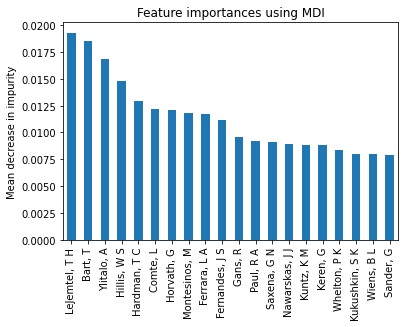

In [33]:
#visualization of the top 20 features sorted by importance
fig, ax = plt.subplots()
forest_importances.head(20).plot.bar(ax=ax)
plt.title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

## Models training and resuls

In [34]:
#creating dataset to save results
res = pd.DataFrame() 

In [35]:
#cross validation k=5
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)


DATASET 0 


Split number 1 

Training matrix: (2035, 12964)
Test matrix: (509, 12964)

SVM RESULTS:


F-2 score with dataset 0 : 0.5681818181818181 

F-3 score with dataset 0 : 0.5952380952380953 



,precision,recall,f1-score,support
0,0.994,0.986,0.990,501.00
1,0.417,0.625,0.500,8.00
accuracy,0.980,0.980,0.980,0.98
macro avg,0.705,0.806,0.745,509.00
weighted avg,0.985,0.980,0.982,509.00



DT RESULTS:


F-2 score with dataset 0 : 0.25 

F-3 score with dataset 0 : 0.25 



,precision,recall,f1-score,support
0,0.988,0.988,0.988,501.000
1,0.250,0.250,0.250,8.000
accuracy,0.976,0.976,0.976,0.976
macro avg,0.619,0.619,0.619,509.000
weighted avg,0.976,0.976,0.976,509.000



RF RESULTS:


F-2 score with dataset 0 : 0.0 

F-3 score with dataset 0 : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,501.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,509.000
weighted avg,0.969,0.984,0.976,509.000



Split number 2 

Training matrix: (2035, 12964)
Test matrix: (509, 12964)

SVM RESULTS:


F-2 score with dataset 0 : 0.35714285714285715 

F-3 score with dataset 0 : 0.3658536585365854 



,precision,recall,f1-score,support
0,0.990,0.986,0.988,501.000
1,0.300,0.375,0.333,8.000
accuracy,0.976,0.976,0.976,0.976
macro avg,0.645,0.681,0.661,509.000
weighted avg,0.979,0.976,0.978,509.000



DT RESULTS:


F-2 score with dataset 0 : 0.23809523809523808 

F-3 score with dataset 0 : 0.24390243902439027 



,precision,recall,f1-score,support
0,0.988,0.984,0.986,501.000
1,0.200,0.250,0.222,8.000
accuracy,0.972,0.972,0.972,0.972
macro avg,0.594,0.617,0.604,509.000
weighted avg,0.976,0.972,0.974,509.000



RF RESULTS:


F-2 score with dataset 0 : 0.0 

F-3 score with dataset 0 : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,501.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,509.000
weighted avg,0.969,0.984,0.976,509.000



Split number 3 

Training matrix: (2035, 12964)
Test matrix: (509, 12964)

SVM RESULTS:


F-2 score with dataset 0 : 0.5 

F-3 score with dataset 0 : 0.5555555555555556 



,precision,recall,f1-score,support
0,0.994,0.974,0.984,501.000
1,0.278,0.625,0.385,8.000
accuracy,0.969,0.969,0.969,0.969
macro avg,0.636,0.800,0.684,509.000
weighted avg,0.983,0.969,0.974,509.000



DT RESULTS:


F-2 score with dataset 0 : 0.10204081632653061 

F-3 score with dataset 0 : 0.11235955056179775 



,precision,recall,f1-score,support
0,0.986,0.968,0.977,501.000
1,0.059,0.125,0.080,8.000
accuracy,0.955,0.955,0.955,0.955
macro avg,0.522,0.547,0.528,509.000
weighted avg,0.971,0.955,0.963,509.000



RF RESULTS:


F-2 score with dataset 0 : 0.0 

F-3 score with dataset 0 : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,501.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,509.000
weighted avg,0.969,0.984,0.976,509.000



Split number 4 

Training matrix: (2035, 12964)
Test matrix: (509, 12964)

SVM RESULTS:


F-2 score with dataset 0 : 0.20833333333333331 

F-3 score with dataset 0 : 0.21505376344086016 



,precision,recall,f1-score,support
0,0.986,0.980,0.983,500.000
1,0.167,0.222,0.190,9.000
accuracy,0.967,0.967,0.967,0.967
macro avg,0.576,0.601,0.587,509.000
weighted avg,0.971,0.967,0.969,509.000



DT RESULTS:


F-2 score with dataset 0 : 0.3999999999999999 

F-3 score with dataset 0 : 0.4210526315789473 



,precision,recall,f1-score,support
0,0.990,0.980,0.985,500.000
1,0.286,0.444,0.348,9.000
accuracy,0.971,0.971,0.971,0.971
macro avg,0.638,0.712,0.666,509.000
weighted avg,0.977,0.971,0.974,509.000



RF RESULTS:


F-2 score with dataset 0 : 0.0 

F-3 score with dataset 0 : 0.0 



,precision,recall,f1-score,support
0,0.982,1.000,0.991,500.000
1,0.000,0.000,0.000,9.000
accuracy,0.982,0.982,0.982,0.982
macro avg,0.491,0.500,0.496,509.000
weighted avg,0.965,0.982,0.974,509.000



Split number 5 

Training matrix: (2036, 12964)
Test matrix: (508, 12964)

SVM RESULTS:


F-2 score with dataset 0 : 0.25 

F-3 score with dataset 0 : 0.25 



,precision,recall,f1-score,support
0,0.988,0.988,0.988,500.000
1,0.250,0.250,0.250,8.000
accuracy,0.976,0.976,0.976,0.976
macro avg,0.619,0.619,0.619,508.000
weighted avg,0.976,0.976,0.976,508.000



DT RESULTS:


F-2 score with dataset 0 : 0.10638297872340426 

F-3 score with dataset 0 : 0.11494252873563218 



,precision,recall,f1-score,support
0,0.986,0.972,0.979,500.000
1,0.067,0.125,0.087,8.000
accuracy,0.959,0.959,0.959,0.959
macro avg,0.526,0.548,0.533,508.000
weighted avg,0.971,0.959,0.965,508.000



RF RESULTS:


F-2 score with dataset 0 : 0.0 

F-3 score with dataset 0 : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,500.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,508.000
weighted avg,0.969,0.984,0.976,508.000



DATASET 1 


Split number 1 


SVM RESULTS:


F-2 score with dataset 1 : 0.4347826086956521 

F-3 score with dataset 1 : 0.46511627906976744 



,precision,recall,f1-score,support
0,0.992,0.980,0.986,492.000
1,0.286,0.500,0.364,8.000
accuracy,0.972,0.972,0.972,0.972
macro avg,0.639,0.740,0.675,500.000
weighted avg,0.980,0.972,0.976,500.000



DT RESULTS:


F-2 score with dataset 1 : 0.11363636363636363 

F-3 score with dataset 1 : 0.11904761904761904 



,precision,recall,f1-score,support
0,0.986,0.978,0.982,492.000
1,0.083,0.125,0.100,8.000
accuracy,0.964,0.964,0.964,0.964
macro avg,0.534,0.551,0.541,500.000
weighted avg,0.971,0.964,0.968,500.000



RF RESULTS:


F-2 score with dataset 1 : 0.0 

F-3 score with dataset 1 : 0.0 



,precision,recall,f1-score,support
0,0.984,0.998,0.991,492.000
1,0.000,0.000,0.000,8.000
accuracy,0.982,0.982,0.982,0.982
macro avg,0.492,0.499,0.495,500.000
weighted avg,0.968,0.982,0.975,500.000



Split number 2 


SVM RESULTS:


F-2 score with dataset 1 : 0.44117647058823534 

F-3 score with dataset 1 : 0.43478260869565216 



,precision,recall,f1-score,support
0,0.992,0.994,0.993,492.000
1,0.500,0.429,0.462,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.746,0.711,0.727,499.000
weighted avg,0.985,0.986,0.985,499.000



DT RESULTS:


F-2 score with dataset 1 : 0.14705882352941174 

F-3 score with dataset 1 : 0.14492753623188404 



,precision,recall,f1-score,support
0,0.988,0.990,0.989,492.000
1,0.167,0.143,0.154,7.000
accuracy,0.978,0.978,0.978,0.978
macro avg,0.577,0.566,0.571,499.000
weighted avg,0.976,0.978,0.977,499.000



RF RESULTS:


F-2 score with dataset 1 : 0.0 

F-3 score with dataset 1 : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 3 


SVM RESULTS:


F-2 score with dataset 1 : 0.2941176470588235 

F-3 score with dataset 1 : 0.28985507246376807 



,precision,recall,f1-score,support
0,0.990,0.992,0.991,492.000
1,0.333,0.286,0.308,7.000
accuracy,0.982,0.982,0.982,0.982
macro avg,0.662,0.639,0.649,499.000
weighted avg,0.981,0.982,0.981,499.000



DT RESULTS:


F-2 score with dataset 1 : 0.13513513513513514 

F-3 score with dataset 1 : 0.1388888888888889 



,precision,recall,f1-score,support
0,0.988,0.984,0.986,492.000
1,0.111,0.143,0.125,7.000
accuracy,0.972,0.972,0.972,0.972
macro avg,0.549,0.563,0.555,499.000
weighted avg,0.975,0.972,0.974,499.000



RF RESULTS:


F-2 score with dataset 1 : 0.0 

F-3 score with dataset 1 : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 4 


SVM RESULTS:


F-2 score with dataset 1 : 0.26315789473684204 

F-3 score with dataset 1 : 0.273972602739726 



,precision,recall,f1-score,support
0,0.990,0.984,0.987,492.000
1,0.200,0.286,0.235,7.000
accuracy,0.974,0.974,0.974,0.974
macro avg,0.595,0.635,0.611,499.000
weighted avg,0.979,0.974,0.976,499.000



DT RESULTS:


F-2 score with dataset 1 : 0.3061224489795918 

F-3 score with dataset 1 : 0.3571428571428571 



,precision,recall,f1-score,support
0,0.992,0.963,0.977,492.000
1,0.143,0.429,0.214,7.000
accuracy,0.956,0.956,0.956,0.956
macro avg,0.567,0.696,0.596,499.000
weighted avg,0.980,0.956,0.967,499.000



RF RESULTS:


F-2 score with dataset 1 : 0.0 

F-3 score with dataset 1 : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 5 


SVM RESULTS:


F-2 score with dataset 1 : 0.23255813953488375 

F-3 score with dataset 1 : 0.24096385542168675 



,precision,recall,f1-score,support
0,0.988,0.982,0.985,491.00
1,0.182,0.250,0.211,8.00
accuracy,0.970,0.970,0.970,0.97
macro avg,0.585,0.616,0.598,499.00
weighted avg,0.975,0.970,0.972,499.00



DT RESULTS:


F-2 score with dataset 1 : 0.10416666666666667 

F-3 score with dataset 1 : 0.11363636363636363 



,precision,recall,f1-score,support
0,0.986,0.969,0.977,491.000
1,0.062,0.125,0.083,8.000
accuracy,0.956,0.956,0.956,0.956
macro avg,0.524,0.547,0.530,499.000
weighted avg,0.971,0.956,0.963,499.000



RF RESULTS:


F-2 score with dataset 1 : 0.0 

F-3 score with dataset 1 : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,491.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,499.000
weighted avg,0.968,0.984,0.976,499.000



DATASET 2 


Split number 1 

Training matrix: (1996, 12873)
Test matrix: (500, 12873)

SVM RESULTS:


F-2 score with dataset 2 : 0.3773584905660377 

F-3 score with dataset 2 : 0.4301075268817204 



,precision,recall,f1-score,support
0,0.992,0.965,0.978,492.000
1,0.190,0.500,0.276,8.000
accuracy,0.958,0.958,0.958,0.958
macro avg,0.591,0.733,0.627,500.000
weighted avg,0.979,0.958,0.967,500.000



DT RESULTS:


F-2 score with dataset 2 : 0.3409090909090909 

F-3 score with dataset 2 : 0.35714285714285715 



,precision,recall,f1-score,support
0,0.990,0.982,0.986,492.000
1,0.250,0.375,0.300,8.000
accuracy,0.972,0.972,0.972,0.972
macro avg,0.620,0.678,0.643,500.000
weighted avg,0.978,0.972,0.975,500.000



RF RESULTS:


F-2 score with dataset 2 : 0.0 

F-3 score with dataset 2 : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,492.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,500.000
weighted avg,0.968,0.984,0.976,500.000



Split number 2 

Training matrix: (1997, 12873)
Test matrix: (499, 12873)

SVM RESULTS:


F-2 score with dataset 2 : 0.4054054054054054 

F-3 score with dataset 2 : 0.41666666666666663 



,precision,recall,f1-score,support
0,0.992,0.988,0.990,492.00
1,0.333,0.429,0.375,7.00
accuracy,0.980,0.980,0.980,0.98
macro avg,0.663,0.708,0.682,499.00
weighted avg,0.983,0.980,0.981,499.00



DT RESULTS:


F-2 score with dataset 2 : 0.35714285714285715 

F-3 score with dataset 2 : 0.38961038961038963 



,precision,recall,f1-score,support
0,0.992,0.978,0.985,492.00
1,0.214,0.429,0.286,7.00
accuracy,0.970,0.970,0.970,0.97
macro avg,0.603,0.703,0.635,499.00
weighted avg,0.981,0.970,0.975,499.00



RF RESULTS:


F-2 score with dataset 2 : 0.0 

F-3 score with dataset 2 : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 3 

Training matrix: (1997, 12873)
Test matrix: (499, 12873)

SVM RESULTS:


F-2 score with dataset 2 : 0.34883720930232553 

F-3 score with dataset 2 : 0.3846153846153846 



,precision,recall,f1-score,support
0,0.992,0.976,0.984,492.000
1,0.200,0.429,0.273,7.000
accuracy,0.968,0.968,0.968,0.968
macro avg,0.596,0.702,0.628,499.000
weighted avg,0.981,0.968,0.974,499.000



DT RESULTS:


F-2 score with dataset 2 : 0.11363636363636362 

F-3 score with dataset 2 : 0.12658227848101264 



,precision,recall,f1-score,support
0,0.988,0.970,0.978,492.000
1,0.062,0.143,0.087,7.000
accuracy,0.958,0.958,0.958,0.958
macro avg,0.525,0.556,0.533,499.000
weighted avg,0.975,0.958,0.966,499.000



RF RESULTS:


F-2 score with dataset 2 : 0.0 

F-3 score with dataset 2 : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 4 

Training matrix: (1997, 12873)
Test matrix: (499, 12873)

SVM RESULTS:


F-2 score with dataset 2 : 0.5208333333333334 

F-3 score with dataset 2 : 0.6024096385542169 



,precision,recall,f1-score,support
0,0.996,0.970,0.982,492.000
1,0.250,0.714,0.370,7.000
accuracy,0.966,0.966,0.966,0.966
macro avg,0.623,0.842,0.676,499.000
weighted avg,0.985,0.966,0.974,499.000



DT RESULTS:


F-2 score with dataset 2 : 0.0 

F-3 score with dataset 2 : 0.0 



,precision,recall,f1-score,support
0,0.986,0.980,0.983,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.966,0.966,0.966,0.966
macro avg,0.493,0.490,0.491,499.000
weighted avg,0.972,0.966,0.969,499.000



RF RESULTS:


F-2 score with dataset 2 : 0.0 

F-3 score with dataset 2 : 0.0 



,precision,recall,f1-score,support
0,0.986,1.000,0.993,492.000
1,0.000,0.000,0.000,7.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.493,0.500,0.496,499.000
weighted avg,0.972,0.986,0.979,499.000



Split number 5 

Training matrix: (1997, 12873)
Test matrix: (499, 12873)

SVM RESULTS:


F-2 score with dataset 2 : 0.10204081632653061 

F-3 score with dataset 2 : 0.11235955056179775 



,precision,recall,f1-score,support
0,0.985,0.967,0.976,491.000
1,0.059,0.125,0.080,8.000
accuracy,0.954,0.954,0.954,0.954
macro avg,0.522,0.546,0.528,499.000
weighted avg,0.971,0.954,0.962,499.000



DT RESULTS:


F-2 score with dataset 2 : 0.0 

F-3 score with dataset 2 : 0.0 



,precision,recall,f1-score,support
0,0.984,0.980,0.982,491.000
1,0.000,0.000,0.000,8.000
accuracy,0.964,0.964,0.964,0.964
macro avg,0.492,0.490,0.491,499.000
weighted avg,0.968,0.964,0.966,499.000



RF RESULTS:


F-2 score with dataset 2 : 0.0 

F-3 score with dataset 2 : 0.0 



,precision,recall,f1-score,support
0,0.984,1.000,0.992,491.000
1,0.000,0.000,0.000,8.000
accuracy,0.984,0.984,0.984,0.984
macro avg,0.492,0.500,0.496,499.000
weighted avg,0.968,0.984,0.976,499.000


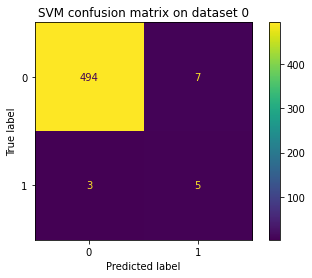

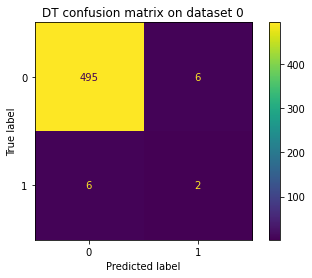

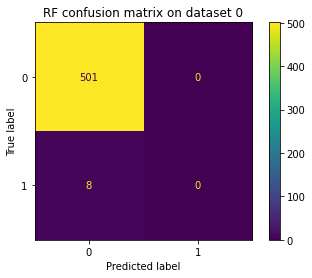

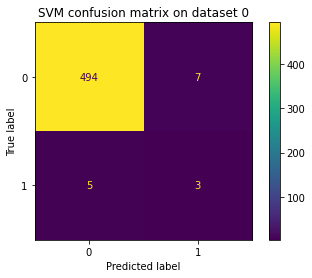

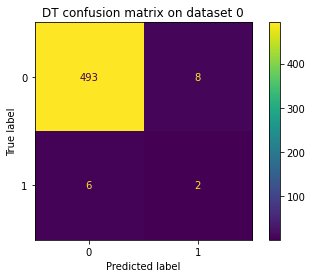

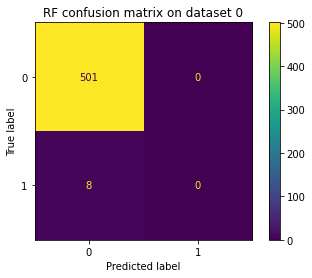

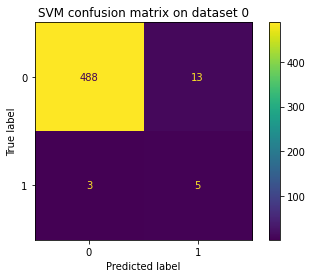

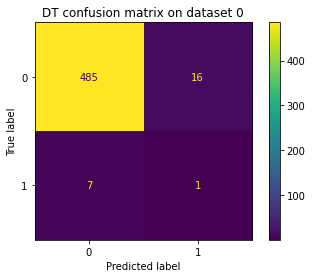

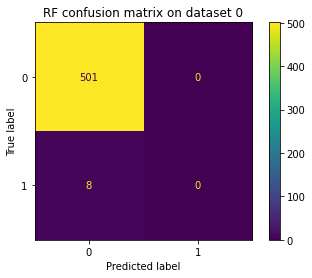

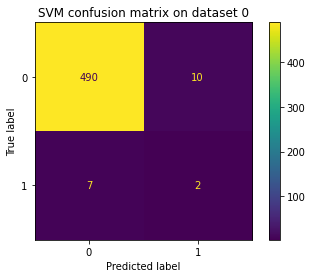

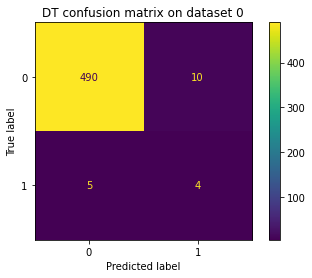

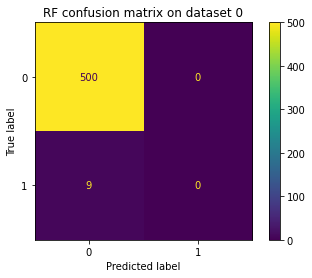

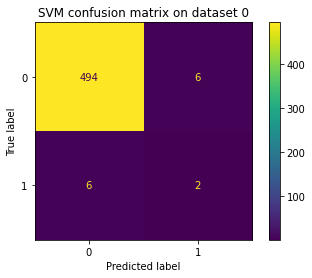

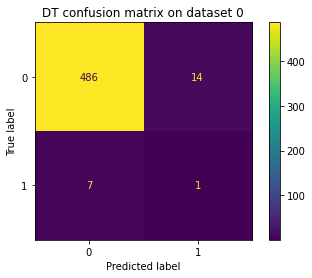

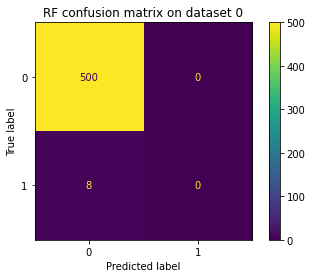

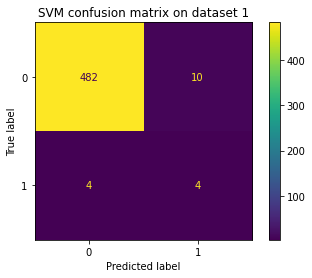

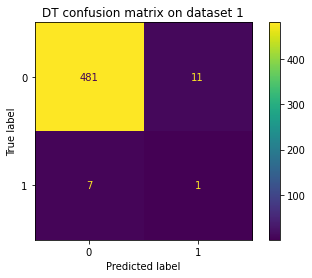

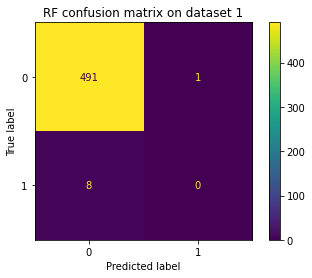

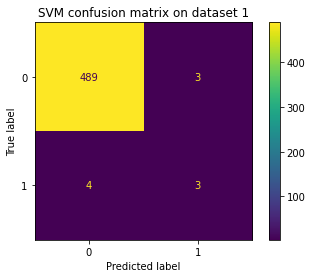

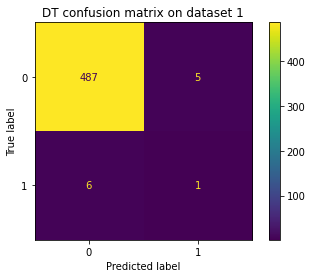

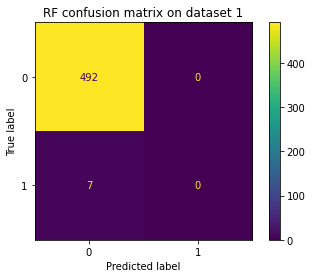

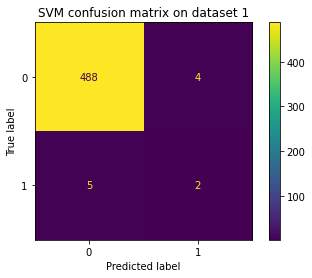

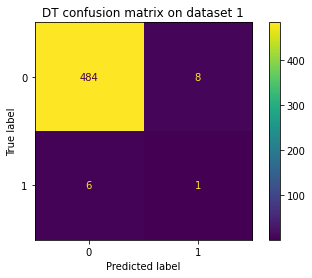

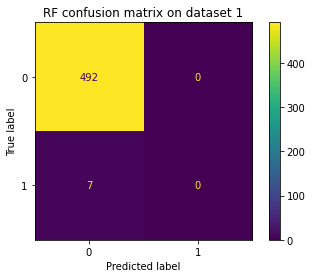

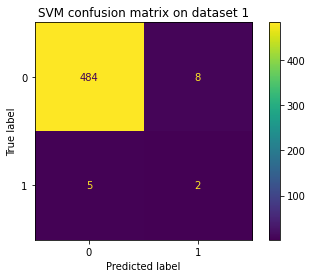

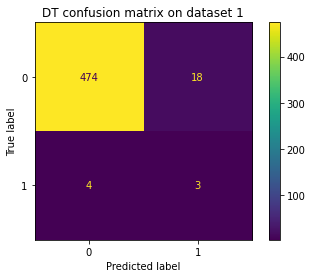

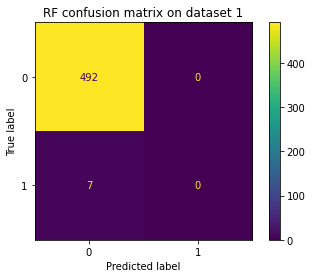

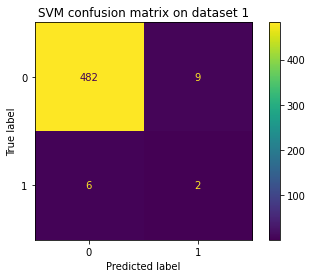

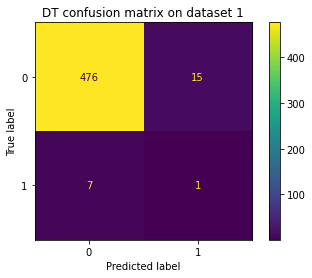

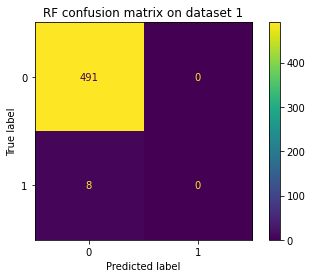

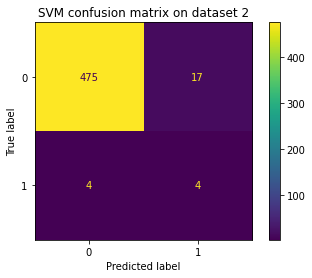

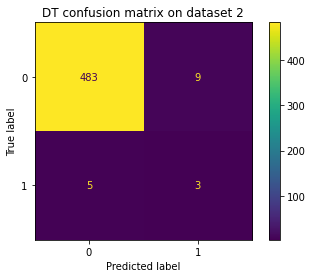

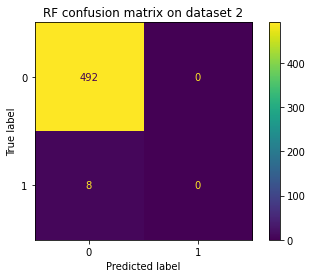

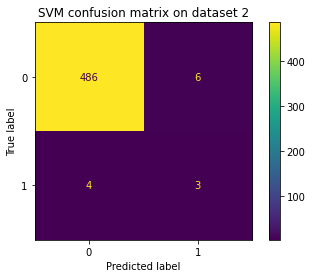

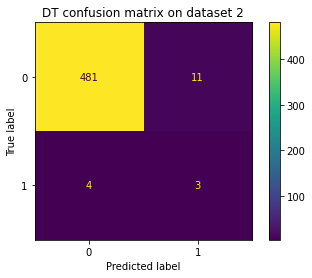

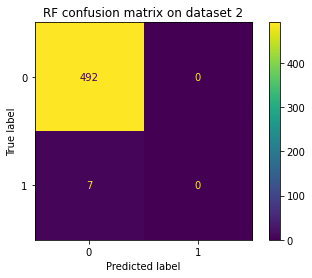

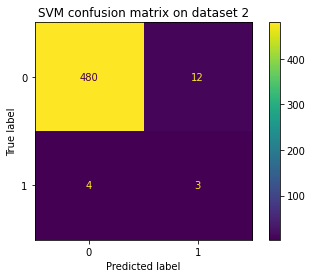

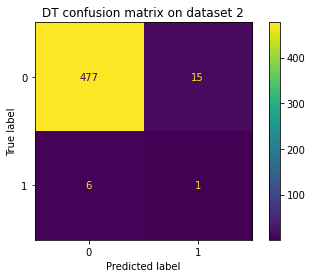

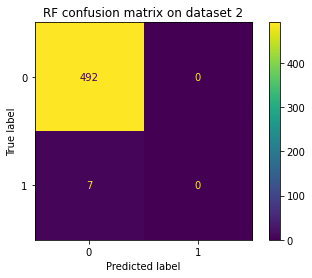

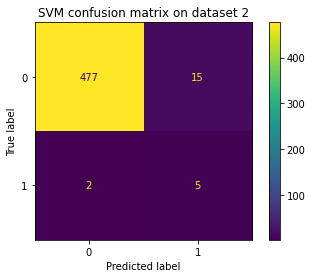

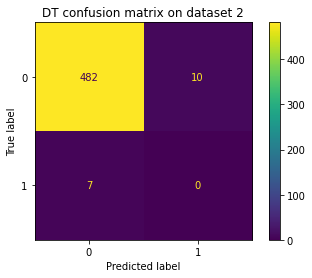

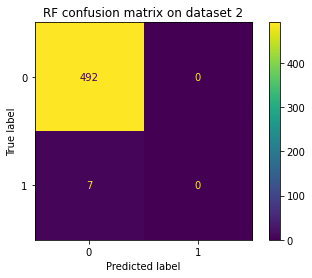

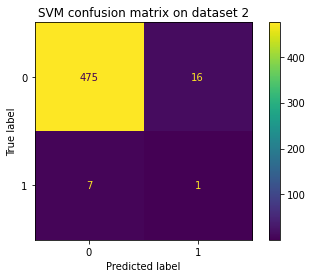

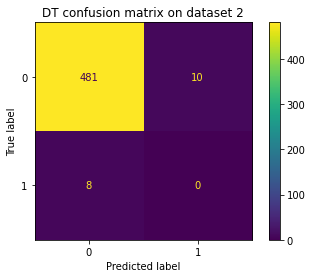

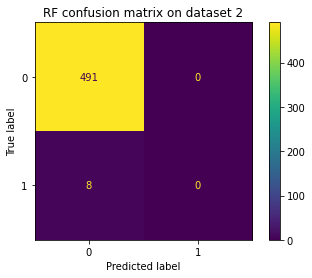

In [36]:
for i in dataset: 

  print("\nDATASET", i, "\n")

  X = dataset[i].loc[:, dataset[i].columns != 'Label']
  y = dataset[i]["Label"]

  j = 0

  for train_index, test_index in skf.split(X, y):

    j = j + 1
    print("\nSplit number", j, "\n")
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #resetting indexes for concat()
    X_train = X_train.reset_index(drop=True) 
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    #tf-idf
    if i != "1": #1 -> df_notext
      all_text = X_train["text_clean"].values.tolist() + X_test["text_clean"].values.tolist()
      vocab = flatten_words(all_text, get_unique=True)
      tfidf = TfidfVectorizer(stop_words='english', vocabulary=vocab)
      training_matrix = tfidf.fit_transform(X_train["text_clean"])
      test_matrix = tfidf.fit_transform(X_test["text_clean"])

      print("Training matrix:", training_matrix.shape)
      print("Test matrix:", test_matrix.shape)

      X_train = pd.concat([X_train, pd.DataFrame(training_matrix.todense())], axis=1)
      X_test = pd.concat([X_test, pd.DataFrame(test_matrix.todense())], axis=1)


    #scaling data
    scaler = StandardScaler()
    features = list(set(X_train.columns) - set(["text", "text_clean", "Label"])) #all columns except text, text_clean and Label
    X_train = scaler.fit_transform(X_train[features].values)
    y_train = y_train.values
    X_test = scaler.transform(X_test[features].values)

    #####

    ## SVM training

    svm = LinearSVC(class_weight="balanced", random_state=1)
    svm = svm.fit(X_train, y_train)

    ## SVM results

    #prediction on the test set
    test_predicted = svm.predict(X_test) 

    #evaluation metrics
    print("\nSVM RESULTS:\n")
    new_row = {"df" : i, "train_shape" : X_train.shape, "test_shape" : X_test.shape, 
               "fold" : j, "model" : "SVM"}
    res = evalmetrics(y_test, test_predicted, svm.classes_, new_row, res)

    ######

    ## DT training

    dt = tree.DecisionTreeClassifier(class_weight="balanced", random_state=1)
    dt = dt.fit(X_train, y_train)

    ## DT results

    #prediction on the test set
    test_predicted = dt.predict(X_test)

    #evaluation metrics
    print("\nDT RESULTS:\n")
    new_row = {"df" : i, "train_shape" : X_train.shape, "test_shape" : X_test.shape, 
               "fold" : j, "model" : "DT"}
    res = evalmetrics(y_test, test_predicted, svm.classes_, new_row, res)

    ######

    # RF training

    forest = RandomForestClassifier(class_weight="balanced", random_state=1)
    forest = forest.fit(X_train, y_train)
    ## RF results

    #prediction on the test set
    test_predicted = forest.predict(X_test)

    #evaluation metrics
    print("\nRF RESULTS:\n")
    new_row = {"df" : i, "train_shape" : X_train.shape, "test_shape" : X_test.shape, 
               "fold" : j, "model" : "RF"}
    res = evalmetrics(y_test, test_predicted, svm.classes_, new_row, res)

# computation of mean metrics
res = compute_fbeta_avg(res)

In [37]:
res.head(3)

,df,train_shape,test_shape,fold,model,f2_score,f3_score,f2_avg,f3_avg
0,0,"(2035, 12964)","(509, 12964)",1.0,SVM,0.568182,0.595238,0.376732,0.396340
1,0,"(2035, 12964)","(509, 12964)",1.0,DT,0.250000,0.250000,0.219304,0.228451
2,0,"(2035, 12964)","(509, 12964)",1.0,RF,0.000000,0.000000,0.000000,0.000000


In [38]:
res.shape

(45, 9)

In [39]:
#saving results in a csv file
filepath = Path('/content/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
res.to_csv(filepath) 